In [ ]:
import matplotlib.pylab as plt
import tensorflow as tf

In [ ]:
!pip install -U tf-hub-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 5.2 MB/s 


In [ ]:
url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'
classifier_url = url

In [ ]:
IMAGE_SHAPE = (224 , 224)

classifier = tf.keras.Sequential([
                                  hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [ ]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


73728/61306 [====================================] - 0s 0us/step


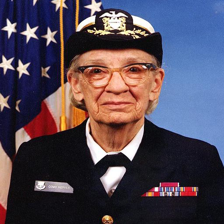

In [ ]:
import numpy as np
import PIL.Image as Image

url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg'
grace_hopper = tf.keras.utils.get_file('image.jpg', url)
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

# 정규화

In [ ]:
grace_hopper = np.array(grace_hopper) / 225.0
grace_hopper.shape

(224, 224, 3)

# 예측

In [ ]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

# argmax로 인덱스 찾기

In [ ]:
predicted_class = np.argmax(result[0], axis = -1)
                        # 원 핫 인코딩으로 진행하여서
                        # index를 불러올때는 argmax를 사용
predicted_class

653

# label 받기

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', url)
imagenet_labels = np.array(open(labels_path).read().splitlines())

24576/10484 [======================================================================] - 0s 0us/step


# 확인

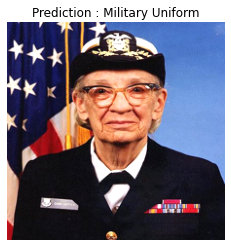

In [ ]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title('Prediction : ' + predicted_class_name.title())

# 이번에는 꽃

In [12]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_root = tf.keras.utils.get_file(
    'flower_photos', url,
    untar=True
)

228827136/228813984 [==============================] - 2s 0us/step


### rescale 및 라벨 인식


In [13]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size = IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


### image_batch 생성

In [14]:
for image_batch, label_batch in image_data:
    print('Image batch shape : ', image_batch.shape)
    print('Label batch shape : ', label_batch.shape)
    break

Image batch shape :  (32, 224, 224, 3)
Label batch shape :  (32, 5)


# 배치 한 세트에 대한 예측 결과

In [15]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [16]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['orange', 'cardoon', 'daisy', 'rapeseed', 'barn spider', 'daisy',
       'daisy', 'sea urchin', 'feather boa', 'hip', 'daisy', 'rapeseed',
       'cardoon', 'pot', 'daisy', 'picket fence', 'daisy', 'daisy',
       'vase', 'daisy', 'daisy', 'daisy', 'sulphur butterfly', 'orange',
       "yellow lady's slipper", "jack-o'-lantern", 'pot', 'daisy',
       'fur coat', 'weevil', 'rapeseed', 'spindle'], dtype='<U30')

# 확인

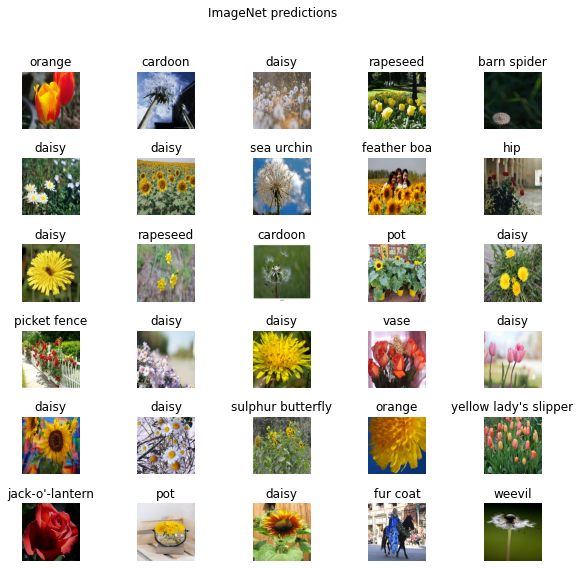

In [17]:
plt.figure(figsize = (10, 9))
plt.subplots_adjust(hspace = 0.5)
for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle('ImageNet predictions')

# 다시 특징 추출기

In [19]:
feature_extractor_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2'

feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224, 224, 3))

In [20]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


# Dense 레이어 추가

In [21]:
feature_extractor_layer.trainable  = False

model = tf.keras.Sequential([
                             feature_extractor_layer,
                             layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


# 마지막 층 

In [22]:
predictions = model(image_batch)

In [23]:
predictions.shape

TensorShape([32, 5])

# Compile

In [24]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'categorical_crossentropy',
    metrics=['acc']
)

# Callback

In [25]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs = None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

# 학습

In [26]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/2
115/115 [==============================] - 17s 118ms/step - loss: 0.4664 - acc: 0.8125
Epoch 2/2
115/115 [==============================] - 13s 116ms/step - loss: 0.3737 - acc: 0.9062


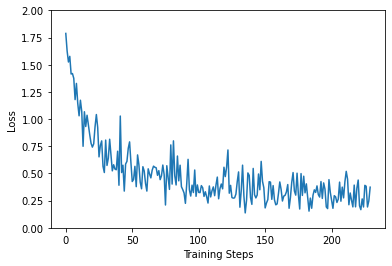

In [27]:
# loss 
plt.figure()
plt.ylabel('Loss')
plt.xlabel('Training Steps')
plt.ylim([0, 2])
plt.plot(batch_stats_callback.batch_losses)

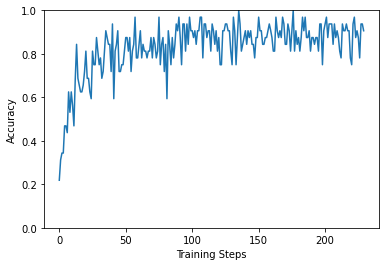

In [28]:
# acc
plt.figure()
plt.ylabel('Accuracy')
plt.xlabel('Training Steps')
plt.ylim([0, 1])
plt.plot(batch_stats_callback.batch_acc)

# class name 할당

In [29]:
class_names = sorted(image_data.class_indices.items(), key = lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [30]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis = -1)

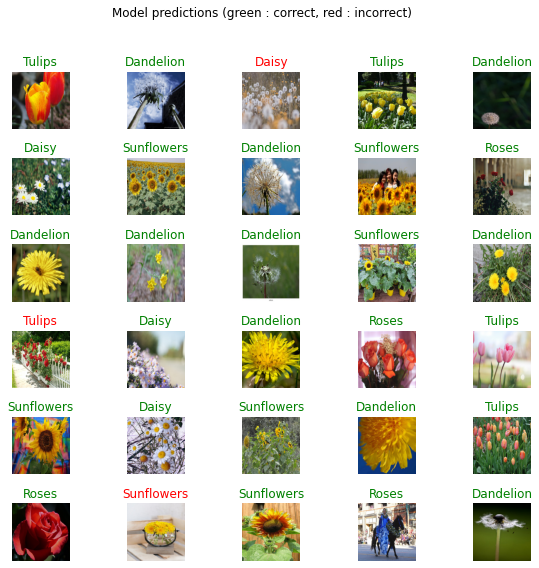

In [33]:
plt.figure(figsize = (10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    color = 'green' if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle('Model predictions (green : correct, red : incorrect)')

In [34]:
# model save
import time
t = time.time()

export_path = './{}'.format(int(t))
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: ./1655691631/assets


INFO:tensorflow:Assets written to: ./1655691631/assets


'./1655691631'

In [35]:
# load model
reloaded = tf.keras.models.load_model(export_path)

In [36]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [37]:
abs(reloaded_result_batch - result_batch).max()
    # 불러온 모델과
                                # 아까 결과가
                                        # 같은 모델이 맞는지 확인하는 과정

0.0